In [1]:
from surprise.prediction_algorithms import NormalPredictor, SVD, NMF
from surprise import Dataset, Reader
from surprise.model_selection import GridSearchCV, cross_validate, KFold as KFold_sp

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.layers import Input, Embedding, Flatten, Dropout, Dense, Concatenate, Lambda
from keras.models import Model
from keras import callbacks
from keras.regularizers import l2

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_validate as cv_sk, KFold as KFold_sk, train_test_split as tts_sk
from sklearn.neighbors import KNeighborsRegressor as KNN

from sentence_transformers import SentenceTransformer
roberta = SentenceTransformer('stsb-roberta-large')

In [2]:
ratings_df = pd.read_csv('ratings.csv')
ratings_df = ratings_df.drop(ratings_df.columns[-1], axis=1)

tags = pd.read_csv('tags.csv')
tags = tags.drop(tags.columns[-1], axis=1)

ratings = Dataset.load_from_df(ratings_df, Reader(rating_scale=(1, 5)))
kf_sp = KFold_sp(n_splits=5, shuffle=False)

ratings_mat = ratings_df.to_numpy()
kf_sk = KFold_sk(n_splits=5, shuffle=False)

# 1. Random Guess

In [3]:
# No hyperparameter needed to fine-tune
rp = NormalPredictor()
rp_res = cross_validate(rp, ratings, measures=['RMSE'], cv=kf_sp, n_jobs=-1)['test_rmse']
print(rp_res)

[1.44330023 1.44180732 1.43211356 1.44325156 1.41702366]


# 2. KNN

In [3]:
# tag_ratings = ratings_df.merge(tags, on=['userId', 'movieId'], how='left') \
#   .drop_duplicates(subset=['userId', 'movieId']).fillna('').reset_index(drop=True)
# vecs = roberta.encode(tag_ratings.iloc[:, -1])
# np.save('encodedText', vecs)

vecs = np.load('encodedText.npy')

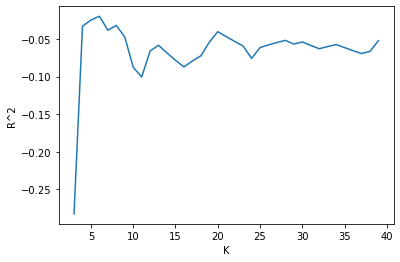

the highest R^2 is at k=6


In [4]:
# Need to fine-tune the number of neighbor (k)
res = []
k = range(3, 40, 1)

X_train, X_test = tts_sk(vecs, test_size=.25, shuffle=False)
train_data, test_data = tts_sk(ratings_mat, test_size=.25, shuffle=False)
for i in k:
    knn = KNN(n_neighbors=i, n_jobs=-1)
    res.append(knn.fit(X_train, train_data[:, -1]).score(X_test, test_data[:, -1]))

plt.plot(k, res)
plt.xlabel('K')
plt.ylabel('R^2')
plt.show()
print(f'the highest R^2 is at k={k[res.index(max(res))]}')

# 3. Non-negative matrix factorization

In [15]:
# Need to fine-tune the number of factors, and epoch number
param_grid = {'n_factors': range(10, 20, 1)}

gs = GridSearchCV(NMF, param_grid, cv=kf_sp, measures=['rmse'], n_jobs=-1)
gs.fit(ratings)

print(gs.best_score['rmse'], gs.best_params['rmse'])

1.056567451480814 {'n_factors': 17}


In [17]:
param_grid = {'n_epochs': range(20, 100, 10)}

gs = GridSearchCV(NMF, param_grid, cv=kf_sp, measures=['rmse'], n_jobs=-1)
gs.fit(ratings)

print(gs.best_score['rmse'], gs.best_params['rmse'])

1.0567111132222702 {'n_epochs': 30}


In [18]:
nmf = NMF(n_factors=17, random_state=12345, n_epochs=30)
nmf_res = cross_validate(nmf, ratings, measures=['RMSE'], cv=kf_sp, n_jobs=-1)['test_rmse']
nmf_res

array([1.0624212 , 1.06406225, 1.05011606, 1.07601778, 1.03480466])

# 4. Singular Value Decomposition

In [21]:
# Need to fine-tune the number of factors, and epoch number
param_grid = {'n_factors': range(5, 15, 1)}

gs = GridSearchCV(SVD, param_grid, cv=kf_sp, measures=['rmse'], n_jobs=-1)
gs.fit(ratings)

print(gs.best_score['rmse'], gs.best_params['rmse'])

0.9829946083734262 {'n_factors': 7}


In [25]:
param_grid = {'n_epochs': range(50, 551, 100)}

gs = GridSearchCV(SVD, param_grid, cv=kf_sp, measures=['rmse'], n_jobs=-1)
gs.fit(ratings)

print(gs.best_score['rmse'], gs.best_params['rmse'])

0.9771587866052149 {'n_epochs': 550}


In [26]:
svd = SVD(n_factors=7, n_epochs=550, random_state=12345)
svd_res = cross_validate(svd, ratings, measures=['RMSE'], cv=kf_sp, n_jobs=-1)['test_rmse']
svd_res

array([1.00215502, 0.9937079 , 0.97379273, 0.99905977, 0.97010309])

# 5. Neural Network

In [4]:
temp_df = pd.DataFrame()
user_enc = LabelEncoder()
temp_df['user'] = user_enc.fit_transform(ratings_df['userId'].values)
item_enc = LabelEncoder()
temp_df['movie'] = item_enc.fit_transform(ratings_df['movieId'].values)
temp_df['rating'] = ratings_df['rating'].values.astype(np.float32)

n_users = temp_df['user'].nunique()
n_movies = temp_df['movie'].nunique()
min_rating = min(temp_df['rating'])
max_rating = max(temp_df['rating'])

temp = temp_df.to_numpy()

In [4]:
def build_model(factors):
    tf.keras.backend.clear_session()

    user = Input(shape=(1,))
    u = Embedding(n_users, factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(user)
    u = Flatten()(u)

    movie = Input(shape=(1,))
    m = Embedding(n_movies, factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(movie)
    m = Flatten()(m)

    x = Concatenate()([u, m])

    x = Dense(16, activation='relu', kernel_initializer='he_normal')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(1, activation='sigmoid', kernel_initializer='he_normal')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)

    model = Model([user, movie], x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

earlystop = callbacks.EarlyStopping(patience=3,
                                    monitor='val_loss',
                                    restore_best_weights=True)

In [5]:
results = []

for i in [16, 32, 50, 64]:
    results_dp = []
    
    for train_index, test_index in kf_sk.split(temp):
        train, test = temp[train_index], temp[test_index]
        model = build_model(i)
        history = model.fit([train[:, 0], train[:, 1]], train[:, 2], epochs=10, verbose=0, callbacks=[earlystop], batch_size=64, validation_split=0.1)
        res = mse(test[:, 2], model.predict([test[:, 0], test[:, 1]]), squared=False)
        results_dp.append(res)
    
    results.append([results_dp])

In [8]:
for i in range(4):
    print(f'n_factors={[16, 32, 50, 64][i]}\t mean RMSE={np.mean(results[i]):.4f}\t with std={np.std(results[i]):.4f}')

n_factors=16	 mean RMSE=0.9627	 with std=0.0245
n_factors=32	 mean RMSE=0.9625	 with std=0.0242
n_factors=50	 mean RMSE=0.9648	 with std=0.0262
n_factors=64	 mean RMSE=0.9632	 with std=0.0238


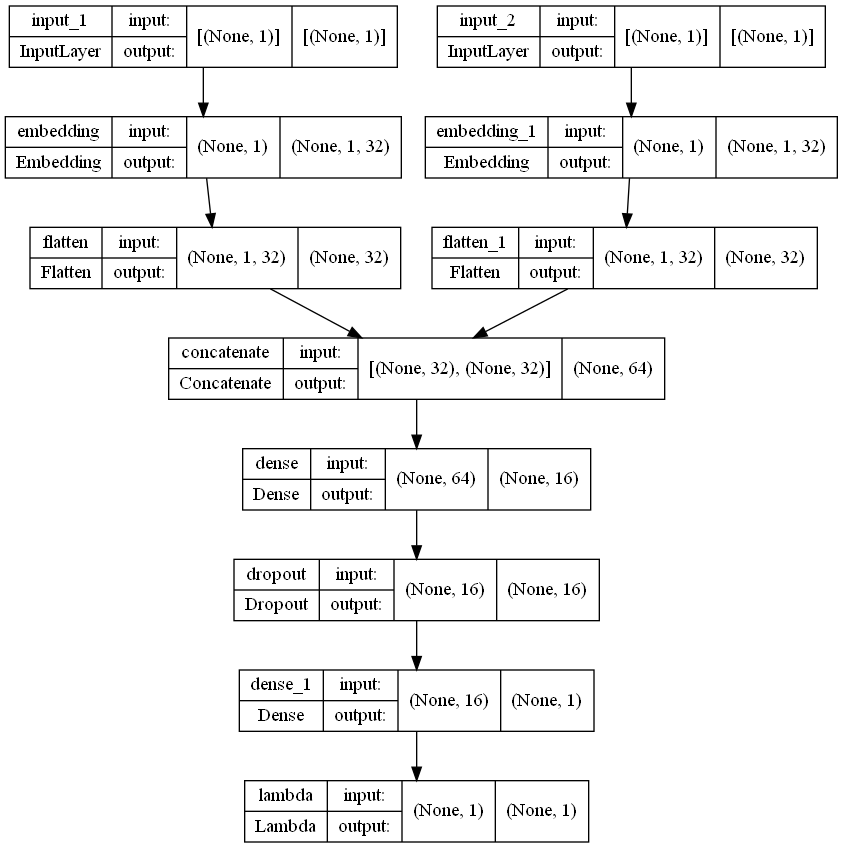

In [9]:
tf.keras.utils.plot_model(model = build_model(32), show_shapes=True)